In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, TimeDistributed, Dropout
import pickle
import numpy as np
import yfinance as yf
import pandas as pd
import math
from tqdm import tqdm
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
tickers = ['TSLA', 'AAPL', 'MSFT', 'GOOG', 'AMZN']

In [4]:
# Download stock data
def download_data():
    raws = {}
    print('Downloading Data')
    for ticker in tqdm(tickers):
        try:
            t = yf.Ticker(ticker)
            t_data = t.history(period='10y', interval='1d')
            if not t_data.empty:
                raws[ticker] = t_data.drop(columns=['Dividends', 'Stock Splits'])
            else:
                print(f"No data for {ticker}, skipping...")
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    print('Done')
    return raws

In [5]:
raws = download_data()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]

Done


In [6]:
def z_score(df, f1, f2, f3):
    df['DayOfWeek'] = [i.dayofweek for i in df.index]
    for column in df.columns:
        std = df[column].std()
        mean = df[column].mean()
        df[column] = (df[column] - mean) / std if std != 0 else 0
        if column == 'Close':
            f1 = (f1 - mean) / std if std != 0 else 0
            f2 = (f2 - mean) / std if std != 0 else 0
            f3 = (f3 - mean) / std if std != 0 else 0
    nan_flag = df.isnull().values.any() or math.isnan(f1) or math.isnan(f2) or math.isnan(f3)
    return df.values, f1, f2, f3, nan_flag

In [7]:
def sequencify(df):
    s1, s2, s3 = [], [], []
    dropped = 0
    for i in range(len(df.index) - 13):
        sequence, f1, f2, f3, nan_flag = z_score(df.iloc[i:i+10], df['Close'].iloc[i+10], df['Close'].iloc[i+11], df['Close'].iloc[i+12])
        if nan_flag:
            dropped += 1
        else:
            s1.append([sequence, f1])
            s2.append([sequence, f2])
            s3.append([sequence, f3])
    return [s1, s2, s3, dropped]

In [8]:
a1, a2, a3 = [], [], []
dropped = 0
print('Generating sequences...')
results = [sequencify(df) for df in tqdm(raws.values())]
for res in results:
    a1.append(res[0])
    a2.append(res[1])
    a3.append(res[2])
    dropped += res[3]
print(f'Done! Dropped {dropped} sequences.')

Generating sequences...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]

Done! Dropped 0 sequences.


In [9]:
train1, test1 = [], []
RATIO = 0.05
for hist in a1:
    split = math.floor(len(hist) * RATIO)
    train1.extend(hist[:-split])
    test1.extend(hist[-split:])
random.shuffle(train1)
random.shuffle(test1)

In [10]:
print('Saving data...')
with open('./data/train1.pkl', 'wb') as f:
    pickle.dump(train1, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('./data/test1.pkl', 'wb') as f:
    pickle.dump(test1, f, protocol=pickle.HIGHEST_PROTOCOL)
print('Done!')

Saving data...
Done!


In [11]:
del train1, test1, a1, a2, a3  # Free memory

In [12]:
# Load preprocessed data
def load_data():
    with open('./data/train1.pkl', 'rb') as f:
        train_data = pickle.load(f)
    with open('./data/test1.pkl', 'rb') as f:
        test_data = pickle.load(f)
    return train_data, test_data

train_data, test_data = load_data()

In [13]:
# Prepare sequences
X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])
X_test = np.array([x[0] for x in test_data])
y_test = np.array([x[1] for x in test_data])

In [14]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        TimeDistributed(Conv1D(32, 3, activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Flatten()),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [16]:
model = build_cnn_lstm(input_shape)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
model.save('cnn_lstm_stock_model.h5')

Epoch 1/20


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8139 - mae: 0.9293 - val_loss: 1.1638 - val_mae: 0.7488
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2963 - mae: 0.7881 - val_loss: 1.1251 - val_mae: 0.7280
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3365 - mae: 0.7903 - val_loss: 1.1308 - val_mae: 0.7297
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2721 - mae: 0.7852 - val_loss: 1.1296 - val_mae: 0.7296
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2980 - mae: 0.7859 - val_loss: 1.1281 - val_mae: 0.7275
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3607 - mae: 0.7931 - val_loss: 1.1364 - val_mae: 0.7341
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2511 - mae: 0.7646 - val_loss: 1.1360 - val_mae: 0.7322
Epoch 8/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2604 - mae: 0.7756 - val_loss: 1.1327 - val_mae: 0.7306
Epoch 9/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2416 

In [17]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")
print(f"Test Mean Absolute Error (MAE): {mae}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1372 - mae: 0.7494 
Test Loss (MSE): 1.178179383277893
Test Mean Absolute Error (MAE): 0.7555471658706665


In [18]:
# Make predictions
y_pred = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


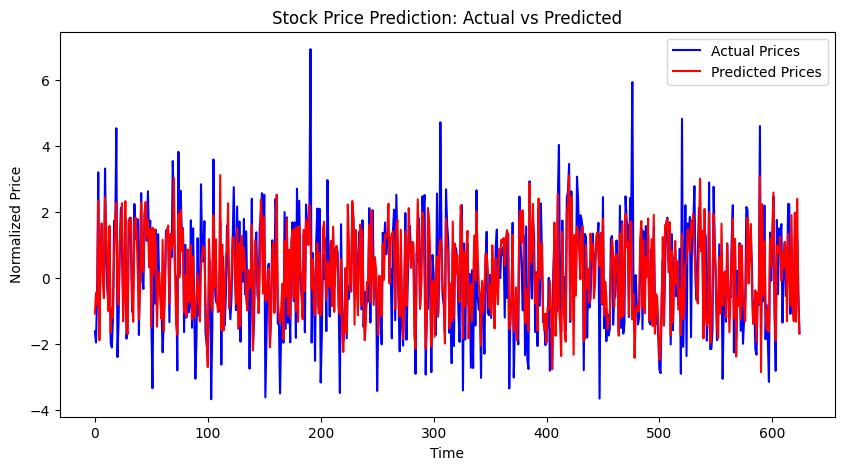

In [21]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", color='red')
plt.legend()
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.show()

In [24]:
# Compute R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.5626
